In [ ]:
using JuMP, Cbc, PyPlot, Images, FileIO, Statistics

# Flows Solver

_Last updated: 29 Jul 19_

Solver for mobile game Flows. Currently written and checked using Julia 1.0. If you see a problem tell me on GitHub or message me somehow.

For those who are unaware, Flows free is a puzzle game where you are given a grid with coloured dots, and you are trying to draw a path connecting the same coloured dots together while not crossing lines and filling all the grid. 

<img src="test1.png" width="20%">

If you have the screenshot of the game itself, can directly feed filepath into `flows_solver` and get the answer.

If you have a similar game which is not Flows, you can enter the problem directly into `find_answer` in a matrix form, like 
```
[1 0 0 0 1,
 2 0 0 0 3,
 0 0 4 0 4,
 0 0 0 0 0,
 2 5 0 5 3]
```

The program below is for solving the puzzle and drawing a completed solution. Run all code blocks below then play around at the bottom of page. 

The solver tries to find solution which fills the entire board. If your solution comes out weird, the problem given might have no solution that fills the entire board (source: experimenting).

Due to a bit of code which involves random number generator, code sometimes break. Happens when youre unlucky enough. Run again and it should be fine (Reason: randomising the place where the grid lines are being detected and sometimes it randomises into bad places).

Code can also take a bit long (some of the larger grids can take up to half an hour). Not sure if it's the solver (Gurobi takes a bit shorter? But it's not free so I didn't use it here) or that there's something with the code that takes a long time, or nothing can be done. Let me know if you can fix it or something.

## Functions

The function below takes in the problem as a 2-D matrix form (generated from other functions below) and defines the problem mathematically and solves it. This problem is a integer linear program, which is formulated as shown below.

### Variables

Suppose we have a problem set which is of size $p \times q$ and there are $c$ different colours.

There are two main sets of variables - one for edges, and one for nodes (which are the boxes in the grid). 

A particular node can be specified by two indices $1 \leq i \leq p$ and $1 \leq j \leq q$ which tells which row and column the node is in. The variables for the nodes are set to be $a_{ijk}$, where $a_{ijk} = 1$ if node at row $i$ and column $j$ is of colour $k$ (where $1 \leq k \leq c$ is the number to represent one of the colours) and is 0 otherwise. They are only allowed to be either 0 or 1. 

For the edges, we divide them into two sets - edges which runs horizontally, and edges which runs vertically. For the edges which runs horizontally, we assign them two indices $1 \leq i \leq p$ and $1 \leq j \leq q$ such that the vertex connected to the left of the edge has the same indices as the edge, i.e. an edge connecting nodes (1, 2) and (1, 3) will be given index (1, 2). Variables used for horizontal edges are assigned as $h_{ijk}$, where $h_{ijk} = 1$ if edge ($i$, $j$) is painted colour $k$, and is 0 otherwise. Vertical edges can be defined in a similar manner but instead using variables $v_{ijk}$. Again, both $h_{ijk}$ and $v_{ijk}$ can only be either 0 or 1.

### Constraints

For notation purposes, we let $[1,x]$ represent a range of number, i.e. $ \{ 1, 2, ..., x \}$. 

The list of constraints are as follows.

- An edge can only be painted at most one colour (they can also not be painted as well).

$$ \sum_{k} v_{ijk} \leq 1 \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c]$$

$$ \sum_{k} h_{ijk} \leq 1 \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c]$$

- A node must be painted exactly one colour (as the game specifies that all of the boxes have a line dragged through).

$$ \sum_{k} a_{ijk} = 1 \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c]$$

- An edge can only be painted a certain colour if the two nodes connected to that edge are both that colour (however if two nodes adjacent to each other are of the same colour they might not have an edge connected between it).

$$ 2 v_{ijk} \leq a_{ijk} + a_{(i+1)jk} \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c] $$

$$ 2 h_{ijk} \leq a_{ijk} + a_{i(j+1)k} \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c] $$

- If a node has no fixed colour, when it is assigned a colour (i.e. a line is drawn through the node), two of the edges connected to it must be painted that colour.

$$ 2 * a_{ijk} = h_{ijk} + h_{(i-1)jk} + v_{ijk} + v_{i(j-1)k} \quad \forall i \in [1,p], \forall j \in [1,q], \forall k \in [1,c] $$

- If a node has a fixed colour (one of the given starting points), then the node has a specified colour. Additionally, only one edge leaving the node can be painted that colour. If the starting node is painted colour $k'$, then the constraints are given as

$$ a_{ijk'} = 1,  \quad h_{ijk'} + h_{(i-1)jk'} + v_{ijk'} + v_{i(j-1)k'} = 1, \quad \forall i \in [1,p], \forall j \in [1,q] $$

Note that in the last three constraints there may be cases where the index is out of range (i.e. when dealing with the edge of the puzzle grid). This can be fixed by adding "ghost" edges and "ghost" nodes which are all set to zero, but will also be a part of the summation so the computer stays happy.

### Objective

This is chosen arbitrarily as this problem only requires a solution, so any feasible answer will be fine. Additionally, there is no suitable measurement of which answer is better than another (as often there will only be one answer to a problem anyway). In case that there are more than one answer in a case, we use the objective as to maximise $\sum_{i, j, k} a_{ijk}$ so that we ensure as much of the grid gets filled - ideally all of it gets filled (I'm 90% sure it doesn't actually matter)

In [60]:
# input: array with all the given dots (each number represents the colours) and number of colours
# output: solved flows problem
function find_answer(array)
    
    m = Model(with_optimizer(Cbc.Optimizer, logLevel=0)) 
    xsize, ysize = size(array)
    n = Int8(findmax(array)[1])
    
    # variable to control the colours of each blocks (and constraints)
    @variable(m, ans[0:xsize+1,0:ysize+1,1:n], Bin)
    @constraint(m, [i=0:xsize+1,k=1:n], ans[i,0,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], ans[i,ysize+1,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], ans[0,j,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], ans[xsize+1,j,k] == 0)
    
    # only one colour in each square
    @constraint(m, [i=1:xsize, j=1:ysize], sum(ans[i,j,:]) == 1)
    
    # variable for edges between each nodes (one variable for edge between two points and which colour)
    @variable(m, hedges[0:xsize,0:ysize+1,1:n], Bin)
    @variable(m, vedges[0:xsize+1,0:ysize,1:n], Bin)
    @constraint(m, [j=0:ysize+1,k=1:n], hedges[0,j,k] == 0)
    @constraint(m, [j=0:ysize+1,k=1:n], hedges[xsize,j,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], vedges[i,0,k] == 0)
    @constraint(m, [i=0:xsize+1,k=1:n], vedges[i,ysize,k] == 0)
    
    # each edges can only be there if colours are the same
    @constraint(m, [i=0:xsize,j=0:ysize+1,k=1:n], ans[i,j,k] + ans[i+1,j,k] >= 2*hedges[i,j,k])
    @constraint(m, [i=0:xsize+1,j=0:ysize,k=1:n], ans[i,j,k] + ans[i,j+1,k] >= 2*vedges[i,j,k])
    
    # at most one of the edges is filled for each colour
    @constraint(m, [i=1:xsize-1,j=1:ysize], sum(hedges[i,j,:]) <= 1)
    @constraint(m, [i=1:xsize,j=1:ysize-1], sum(vedges[i,j,:]) <= 1)
    
    # fix the given points in place
    # and fix the number of edges through each of the points
    for i in 1:xsize
        for j in 1:ysize
            if array[i,j] != 0
                co = array[i,j]
                @constraint(m, ans[i,j,co] == 1)
                @constraint(m, hedges[i-1,j,co] + hedges[i,j,co] + vedges[i,j-1,co] + vedges[i,j,co] == 1)
            else
                @constraint(m, [k=1:n], hedges[i-1,j,k]+hedges[i,j,k]+vedges[i,j-1,k]+vedges[i,j,k] == 2*ans[i,j,k])
            end
        end
    end
    
    @objective(m, Max, sum(ans))
    optimize!(m)
    
    ans_array = JuMP.value.(ans)
    hedges_ans = JuMP.value.(hedges)
    vedges_ans = JuMP.value.(vedges)
    final_answer = zeros(Int8, xsize, ysize)
    for x in 1:xsize
        for y in 1:ysize
            for c in 1:n
                if ans_array[x,y,c] == 1
                    final_answer[x,y] = c
                end
            end
        end
    end
    
    return final_answer, hedges_ans, vedges_ans
    
end

find_answer (generic function with 1 method)

The function below are to detect the board from a screenshot of the game using image processing packages. It detects the grid lines to find size of the puzzle. It returns the coordinates of the rows and columns of game board.

Note that they will sometimes run into a problem, which may require another run of the same code (as it uses a random number generator in there - future fix?)

In [9]:
function detect_board(img,thr=0.1)
    
    grad_y, grad_x, mag, orient = imedge(img)
    sy, sx = size(img)
    
    edges_mat = Array(channelview(mag));
    
    # randomly scan one of the columns, and find where the edges are
    # the boundaries should have edges at a constant place each time, so select those places
    # scan a couple of times
    row_loop = 0
    rows = Set(1:sy)
    while row_loop < 5
        
        test_col = rand(floor(Int,sx*0.2):floor(Int,sx*0.8))
        # if overall edge magnitude here too high then we know that we are on top of a line, so change sample
        if mean(edges_mat[:,test_col]) >= 0.2
            continue
        end
        
        pot_rows = []
        rising = false
        for i in 1:sy
            if edges_mat[i,test_col] > thr && !rising && ((length(pot_rows) == 0) || (i - last(pot_rows) > 4))
                push!(pot_rows,i)
                rising = true
            elseif edges_mat[i,test_col] <= thr && rising
                rising = false
            end
        end
        rows = intersect(rows,pot_rows)
        
        row_loop += 1
    end
    rows = sort(collect(rows))
    
    # detect the position of columns given we know the rows
    cols = Set(1:sx)
    for i in 1:length(rows)-1
        test_row = floor(Int, (rows[i] + rows[i+1])/2)
        pot_cols = []
        rising = false
        for i in 1:sx
            if edges_mat[test_row,i] > thr && !rising && ((length(pot_cols) == 0) || (i - last(pot_cols) > 4))
                push!(pot_cols,i)
                rising = true
            elseif edges_mat[test_row,i] <= thr && rising
                rising = false
            end
        end
        cols = intersect(cols,pot_cols)
    end
    cols = sort(collect(cols))
    
    return rows, cols
    
end

detect_board (generic function with 2 methods)

This function converts problem into a matrix form, given grid locations from `detect_board`.

In [11]:
# Input: two colours in XYZ (closely related to human perception colours)
# Output: similarity index for colours
function colour_similar(c1, c2, thr=0.05)
    return sqrt((c1.x - c2.x)^2 + (c1.y - c2.y)^2 + (c1.z - c2.z)^2) < 0.05
end

# Input: image and colour similar threshold (arbitrary)
# Output: array of the problem, colours of each pair of starting points, and size of problem
function get_problem(img)
    
    rows, cols = detect_board(img)
    xsize = length(rows)-1
    ysize = length(cols)-1
    problem = zeros(Int, (xsize,ysize))
    colours = []
    colour_count = 0
    
    for x in 1:xsize
        for y in 1:ysize
            xco = floor(Int, (rows[x] + rows[x+1])/2)
            yco = floor(Int, (cols[y] + cols[y+1])/2)
            c = img[xco,yco]
            if convert(HSV,c).v > 0.2  # not part of black background
                c = convert(XYZ,c)
                new_colour = true
                for i in 1:colour_count
                    if colour_similar(c, colours[i])
                        new_colour = false
                        problem[x,y] = i
                    end
                end
                if new_colour
                    push!(colours, c)
                    colour_count += 1
                    problem[x,y] = colour_count
                end
            end
        end
    end
    
    convert(Array{ColorTypes.RGB4{FixedPointNumbers.Normed{UInt8,8}},1},colours)
    
    return problem, colours, rows, cols
    
end

get_problem (generic function with 1 method)

This function takes the solution from `find_answer` and draws it out on top of a given image.

In [86]:
function draw_solution(img, img_filename, rows, cols, board_ans, hedges_ans, vedges_ans, colours)
    
    fig = figure()
    ax = fig.add_subplot(111)
    
    imgplot = ax.imshow(imread(img_filename))
    thickness = (size(img)[2]) * 0.07 / (length(cols)-1)
    
    xcos = [floor(Int, (rows[i+1] + rows[i])/2) for i in 1:length(rows)-1]
    ycos = [floor(Int, (cols[i+1] + cols[i])/2) for i in 1:length(cols)-1]
    
    for x in 1:length(xcos)
        for y in 1:length(ycos)
            ci = board_ans[x,y]
            c = convert(RGB, colours[ci])
            if (x+1 <= length(xcos)) && hedges_ans[x,y,ci] == 1
                ax.plot([ycos[y],ycos[y]],[xcos[x],xcos[x+1]],linewidth=thickness,color=(c.r,c.g,c.b))
            end
            if (y+1 <= length(ycos)) && vedges_ans[x,y,ci] == 1
                ax.plot([ycos[y],ycos[y+1]],[xcos[x],xcos[x]],linewidth=thickness,color=(c.r,c.g,c.b))
            end
        end
    end
    
    return fig
    
end

draw_solution (generic function with 3 methods)

This is the function which is a combination of everything above.

In [73]:
# Input: filename
# Output: the solution
function flows_solver(img_filename)
    
    img = load(img_filename)
    
    prob, colours, rows, cols = get_problem(img)
    
    board_ans, h_ans, v_ans = find_answer(prob)
    
    imgplot = draw_solution(img, img_filename, rows, cols, board_ans, h_ans, v_ans, colours)
    
    return imgplot
    
end

flows_solver (generic function with 1 method)

## Demo

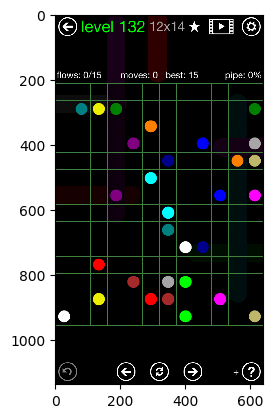

PyObject <matplotlib.image.AxesImage object at 0x150f5e470>

In [101]:
img_filename = "test4.png"
imshow(imread(img_filename), interpolation="nearest")

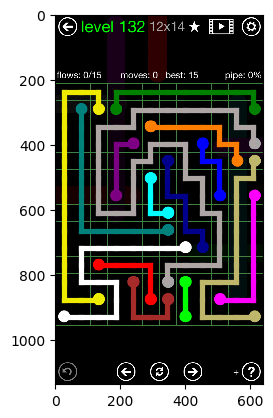

1721.324444 seconds (1.76 M allocations: 189.018 MiB, 0.02% gc time)


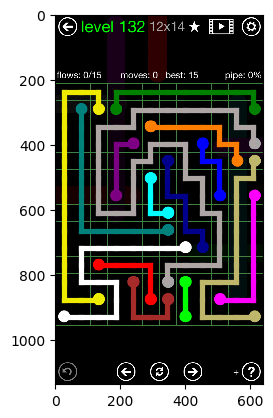

In [102]:
@time flows_solver(img_filename)

In [94]:
@time board_ans, h_ans, v_ans = find_answer([
        1 0 0 0 1;
        2 0 0 0 3;
        0 0 4 0 4;
        0 0 0 0 0;
        2 5 0 5 3;
        6 0 0 0 6
        ])

board_ans

  0.055511 seconds (172.60 k allocations: 6.863 MiB)


6×5 Array{Int8,2}:
 1  1  1  1  1
 2  3  3  3  3
 2  3  4  4  4
 2  3  3  3  3
 2  5  5  5  3
 6  6  6  6  6

In [95]:
h_ans

3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 0:6
    Dimension 2, 0:6
    Dimension 3, 1:6
And data, a 7×7×6 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 4] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [96]:
v_ans

3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 0:7
    Dimension 2, 0:5
    Dimension 3, 1:6
And data, a 8×6×6 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 4] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0